#### Welcome, in this notebook I will present my end-of-course project for the Supervised Machine Learning: Regression course for the IBM Professional Certification in Machine Learning (https://www.coursera.org/professional-certificates/ibm-machine-learning)

#### In this project, we will see the main operations that need to be performed in a regression problem:
- Exploratory Data Analysis;
- Feature Engineering;
- Modeling;
- Validation.

#### The dataset I used can be found at https://www.kaggle.com/datasets/gregorut/videogamesales

#### This dataset contains a list of video games with sales greater than 100,000 copies. It was generated by a scrape of http://www.vgchartz.com/

The features are:

* Rank - Ranking of overall sales
* Name - The games name
* Platform - Platform of the games release (i.e. PC,PS4, etc.)
* Year - Year of the game's release
* Genre - Genre of the game
* Publisher - Publisher of the game
* NA_Sales - Sales in North America (in millions)
* EU_Sales - Sales in Europe (in millions)
* JP_Sales - Sales in Japan (in millions)
* Other_Sales - Sales in the rest of the world (in millions)
* Global_Sales - Total worldwide sales.

#### The first step is to download the dataset. To obtain a dataset from Kaggle, you can either download it through the web interface or use the APIs. To use the APIs, you need to have the 'kaggle' command installed and an access token, which will be a .json file that should be placed in the directory containing the 'kaggle' command (in my case, /root/.kaggle/)

#### As always, I recommend to use Google Colab instead of your machine to run ML application if you don't have GPU or a strong computation support.

In [ ]:
# On Google Colab, it is already installed
!pip install kaggle

In [4]:
!mv /content/kaggle.json /root/.kaggle/

###### Note: if this command give you an error, try to exec the next command the first time, then exec this again

In [ ]:
!kaggle datasets download -d gregorut/videogamesales

In [ ]:
!unzip /content/videogamesales.zip

#### Import the required libraries


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## EDA


Read your chosen dataset into pandas dataframe:


In [9]:
data = pd.read_csv('/content/vgsales.csv')
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


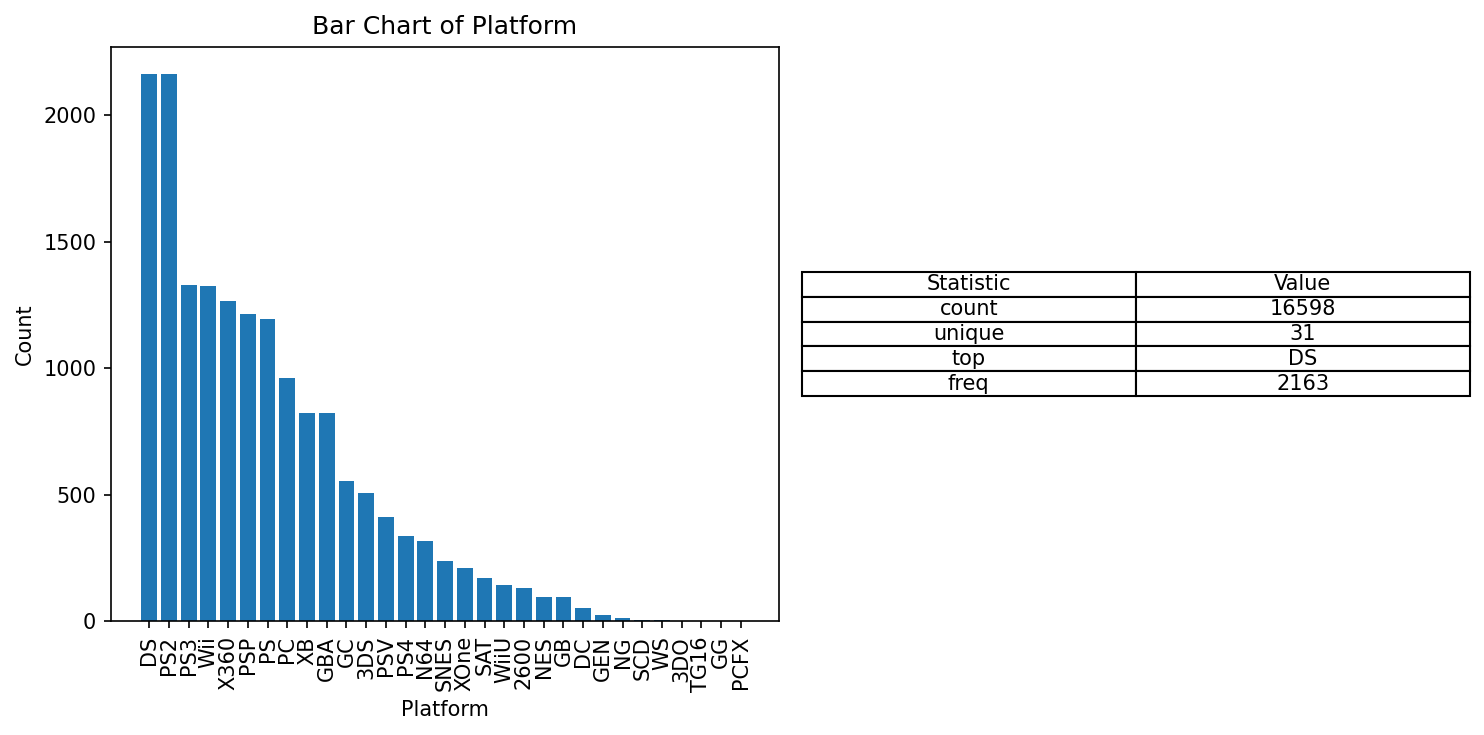

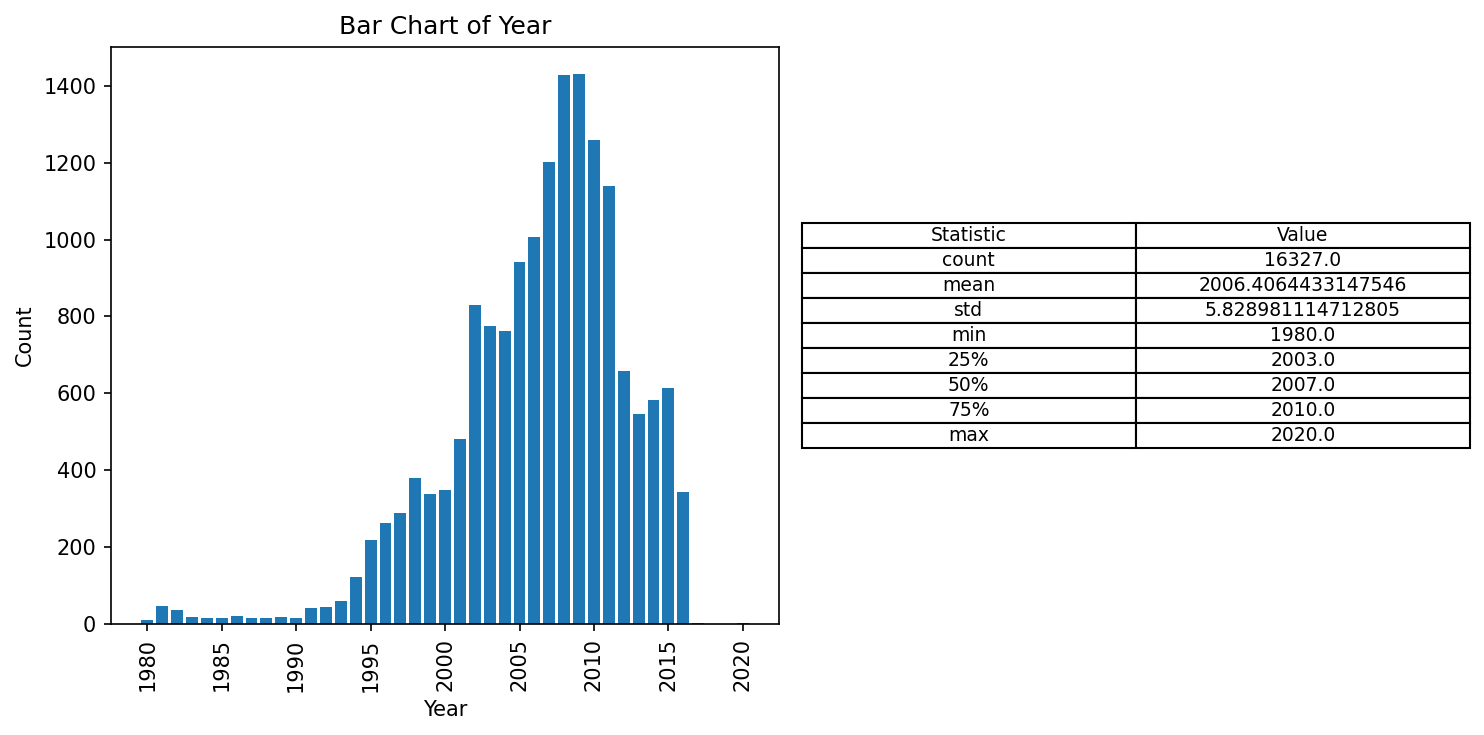

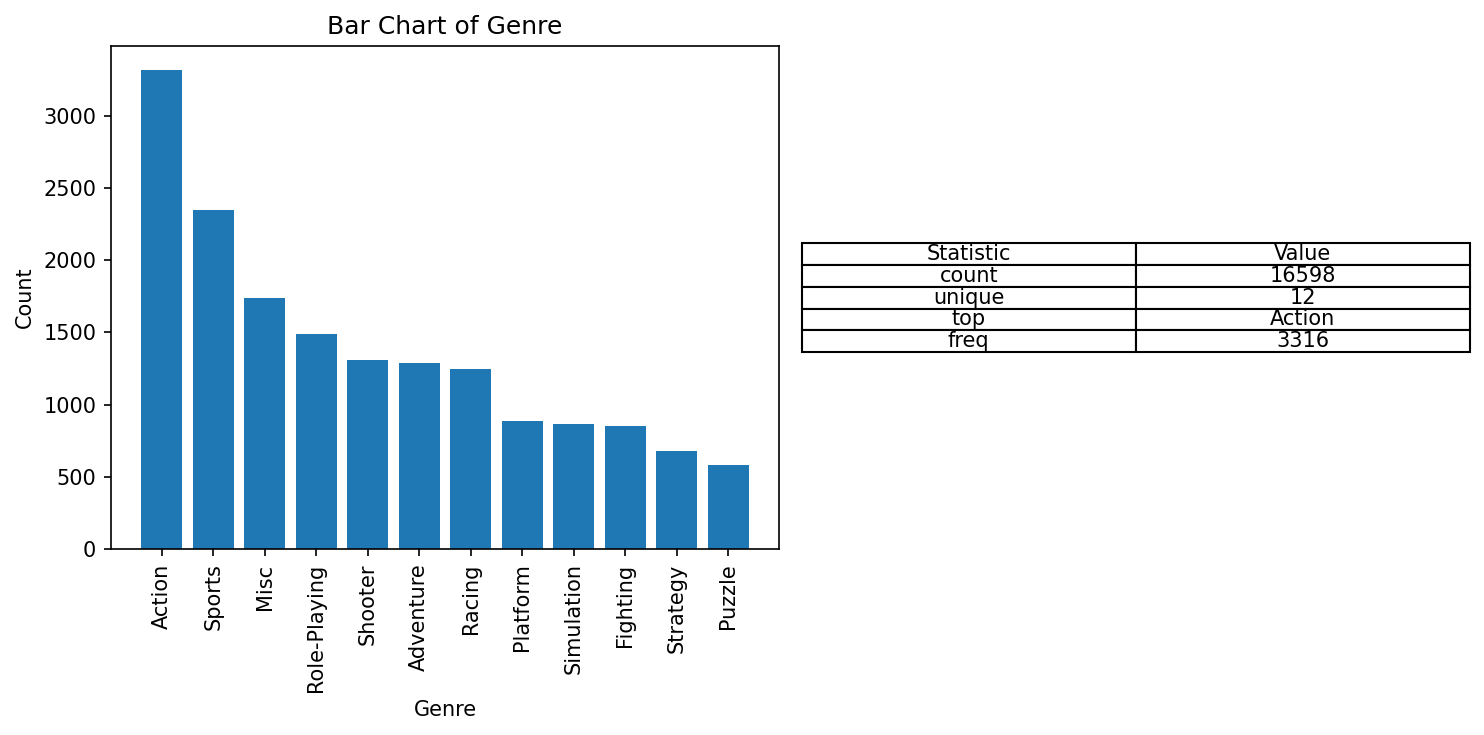

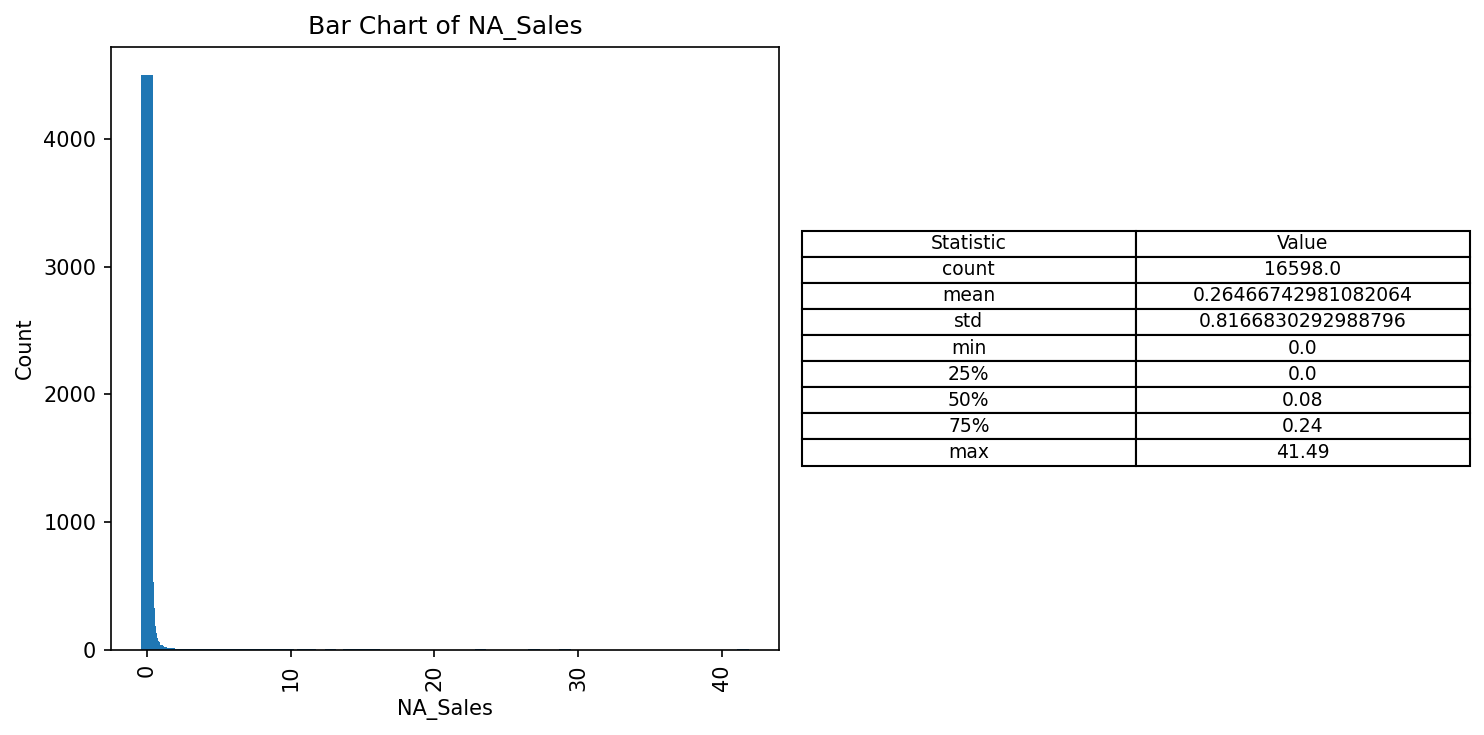

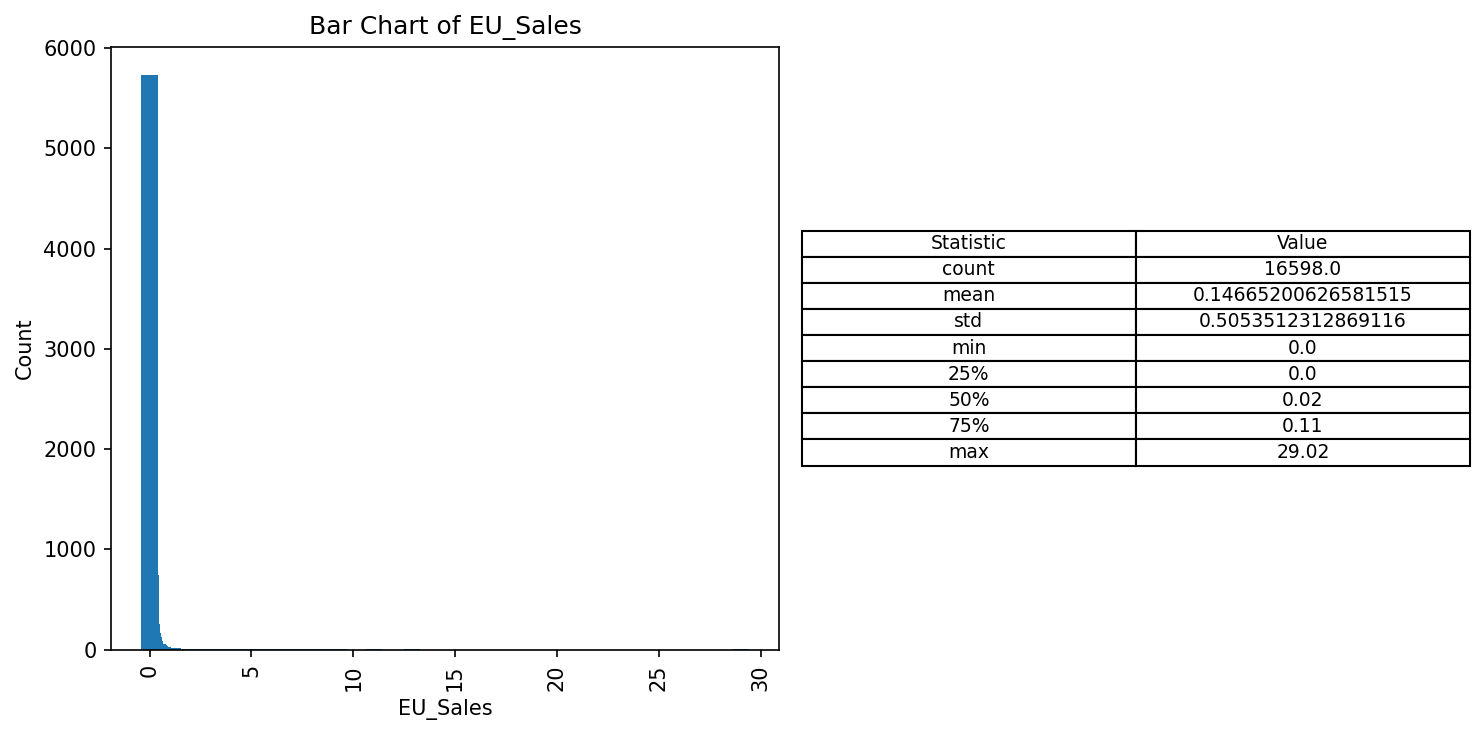

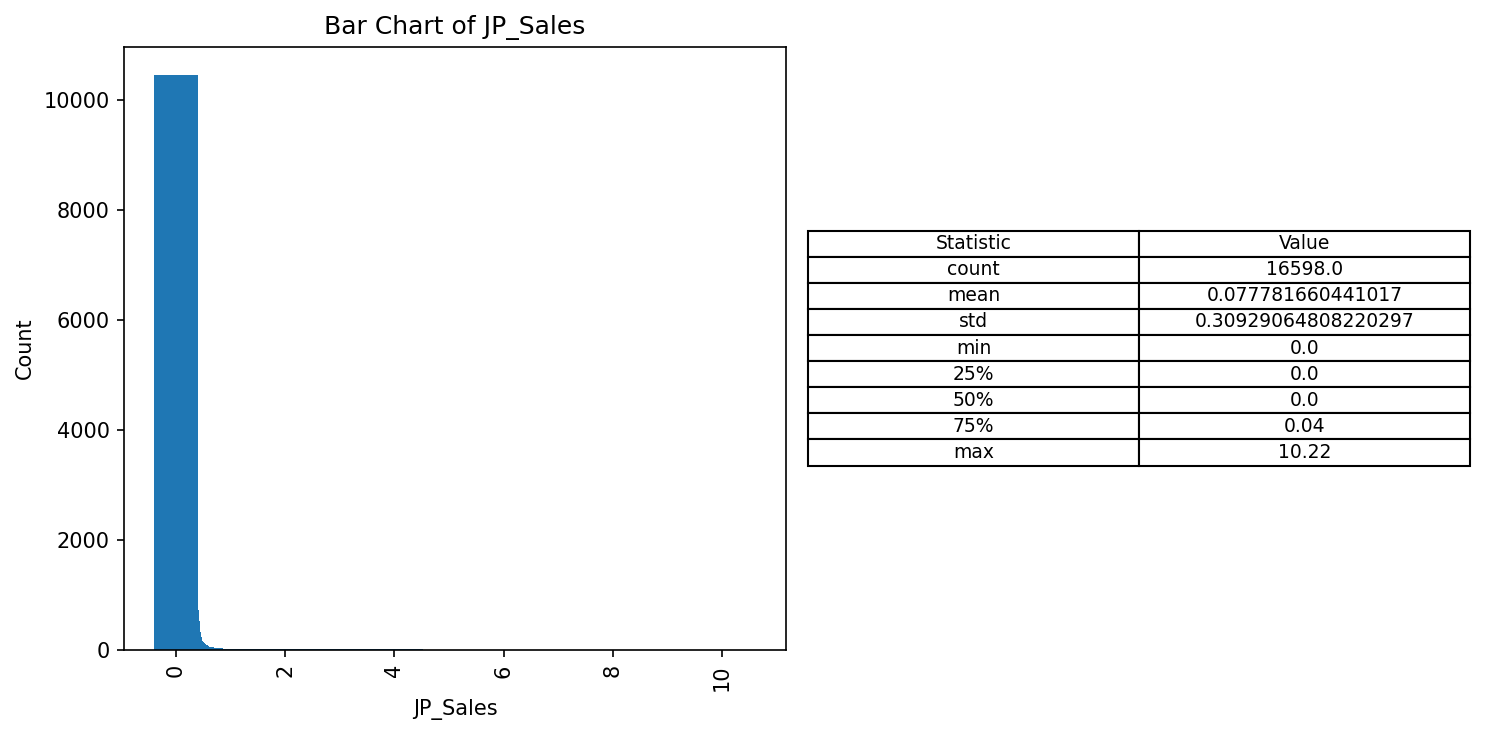

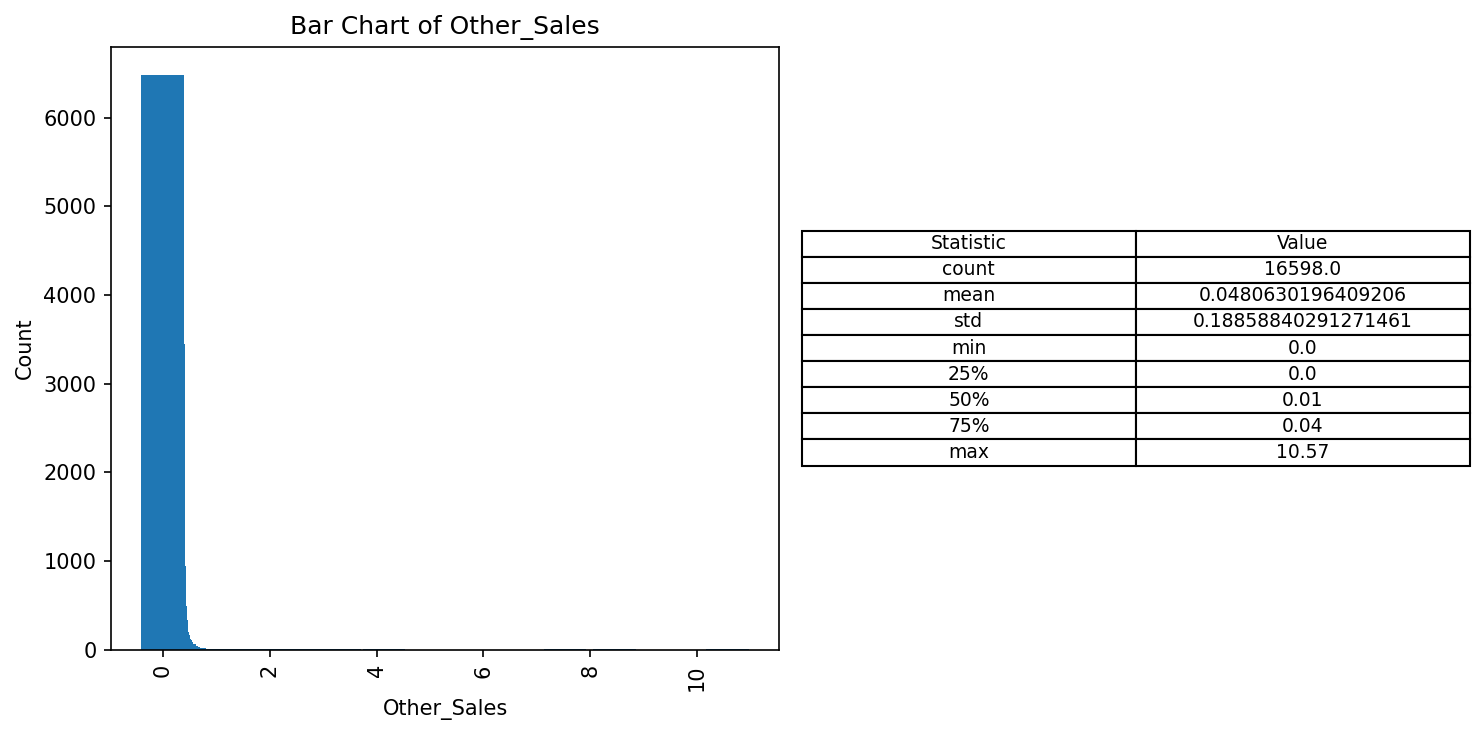

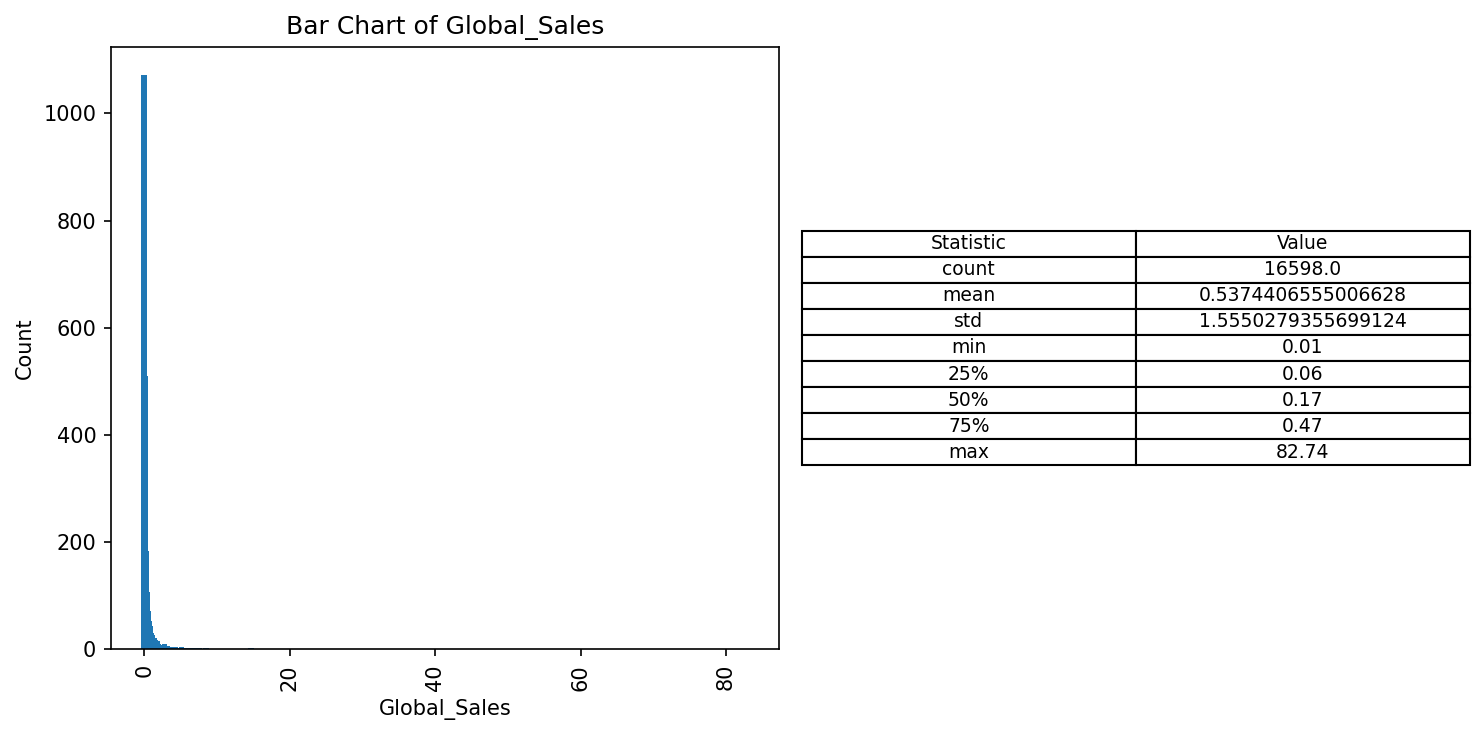

In [10]:
import matplotlib.pyplot as plt

# Define the number of columns for your subplots
num_columns = len(data.drop(['Rank', 'Name', 'Publisher'], axis=1).columns)

# Increase the DPI (dots per inch) for higher resolution
dpi = 150  # Adjust this value for your desired resolution

# Loop through each column and create a separate figure for each chart with statistics
for i, column in enumerate(list(data.drop(['Rank', 'Name', 'Publisher'], axis=1).columns)):
    value_counts = data[column].value_counts()

    # Create a subplot grid with 1 row and 2 columns (for the chart and statistics)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=dpi)  # Adjust the figsize and dpi as needed

    # Plot the bar chart
    ax1 = axes[0]
    ax1.bar(value_counts.index, value_counts)
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.set_title(f'Bar Chart of {column}')
    ax1.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

    # Add statistics table next to the chart
    ax2 = axes[1]
    ax2.axis('off')  # Turn off axis for the statistics table
    stats_table = data[column].describe().reset_index()
    cell_text = []
    for row in stats_table.values:
        cell_text.append([str(val) for val in row])
    ax2.table(cellText=cell_text, colLabels=['Statistic', 'Value'], cellLoc='center', loc='center')

    plt.tight_layout()  # Ensure proper spacing
    plt.savefig(f'bar_chart_with_stats_{column}.png', dpi=dpi, bbox_inches='tight')  # Save each figure as a separate PNG
    plt.show()

#### Thanks to the graphs and tables that display the statistics calculated for each column of the dataset, we can see that the data is well distributed, with tails observed in the distribution that are not strictly outliers, and there's no need to remove them. They represent values attributed to the fact that there are undoubtedly game producers who sell a significantly higher number of copies, and, in general, there are games that sell much more than others. Nevertheless, these values still constitute a meaningful set of data. Furthermore, they do not generate excessive skewness, which, in my opinion, would necessitate transformation.

#### Please note that I am not considering Rank and Name columns because they contain unique values (ID and Name). Additionally, the Publisher column was not included in the printout due to its categorical nature and high variance, making a histogram impractical.

#### We can demonstrate that the high values in the distributions are intrinsic to games and in general to publishers that have been very successful and therefore provide meaningful information

In [11]:
data[['Name', 'Publisher', 'Global_Sales']].sort_values(by='Global_Sales', ascending=False).head(10)

,Name,Publisher,Global_Sales
0,Wii Sports,Nintendo,82.74
1,Super Mario Bros.,Nintendo,40.24
2,Mario Kart Wii,Nintendo,35.82
3,Wii Sports Resort,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,Nintendo,31.37
5,Tetris,Nintendo,30.26
6,New Super Mario Bros.,Nintendo,30.01
7,Wii Play,Nintendo,29.02
8,New Super Mario Bros. Wii,Nintendo,28.62
9,Duck Hunt,Nintendo,28.31


In [12]:
data.groupby('Publisher')['Global_Sales'].sum().reset_index().sort_values(by='Global_Sales', ascending=False).head(10)

,Publisher,Global_Sales
359,Nintendo,1786.56
138,Electronic Arts,1110.32
21,Activision,727.46
456,Sony Computer Entertainment,607.50
525,Ubisoft,474.72
494,Take-Two Interactive,399.54
488,THQ,340.77
275,Konami Digital Entertainment,283.64
446,Sega,272.99
347,Namco Bandai Games,254.09


## Feature Engineering


#### The operations we will perform are:

* Deletion of the 'Rank' and 'Name' columns because they are columns with unique values that do not add value.
* One-hot encoding of the 'Platform', 'Genre' and 'Publisher' columns.
* Normalization of the numerical features.

Note that I manage the year column as a numeric. This is a deliberate choice, because I want to mantain the temporal progressions and trends information

In [ ]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [13]:
# Rank and Name dropped
data.drop(['Rank', 'Name'], axis = 1, inplace = True)

# Platform, Genre and Publisher encoded
one_hot_encode_cols = ['Platform', 'Genre', 'Publisher']
data = pd.get_dummies(data, columns=one_hot_encode_cols)

# Numerical features normalized
numerical_cols = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


data.head(5)

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
0,-0.069730,50.480508,57.136930,11.938058,44.606085,52.864025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-3.672528,35.284437,6.794188,21.767296,3.828224,25.532503,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.273393,19.084273,25.197785,12.002724,17.297115,22.690025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.444955,18.961823,21.497277,10.353740,15.441165,20.876498,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.785348,13.476053,17.302048,32.792857,5.047848,19.828254,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(data.columns)

627

## Modeling


#### Let's start with models. The models we will use are:

* Linear Regressor;
* Ridge and Lasso Regressor;
* Elastic Net regularization;
* Support Vector Regression;
* Random Forest Regression;
* Gradient Boosting Regression;
* Neural Net.

In [14]:
from sklearn.model_selection import train_test_split

# If there are null/missing value for semplicity we pad it with zero

data = data.fillna(0)
train, test = train_test_split(data, test_size=0.25, random_state=42)

In our case we try to predict the Global Sales with all columns except Other Sales. The goal is to train the best model that can predict the global sales with only the information for the best 3 customer target (NA, EU and JP).

In [15]:
feature_cols = [x for x in train.columns if (x != 'Global_Sales' and x != 'Other_Sales')]
X_train = train[feature_cols]
y_train = train['Global_Sales']

X_test  = test[feature_cols]
y_test  = test['Global_Sales']

In [16]:
from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [17]:
# Linear Regressor
from sklearn.linear_model import LinearRegression


linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

print(linearRegression_rmse)

824330306.8187239


The result obtained with a linear regressor without regularization is so bad. It means that without regularization it really suffer overfitting, in particular I think there is multicollinearity among sales feature.

Let's try with regularization

In [18]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas,
                  cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)

80.0 0.08542044766015644


In [19]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=int(5e4),
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse)  # Lasso is slower

0.0001 0.08524416568113594


In [20]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2,
                            l1_ratio=l1_ratios,
                            max_iter=int(1e4)).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

0.0005 0.2 0.08524853981848134


Ok!! With regularization we obtained very good performance. In my opinion, this is a confirmation that the model without a regularization method suffer the strong correlation of certain feature with the target.

Let's try with SVR

In this case, i'm tryng different configuration of hyperparameter using the RandomizedSearchCV function.

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Hyperparameters
param_dist = {
    'C': reciprocal(1, 1000),
    'gamma': reciprocal(0.001, 1),
    'epsilon': uniform(0.01, 0.5)
}

# Support Vector Regressor object
svr = SVR(kernel='rbf')

# RandomizedSearchCV object
random_search = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Model training
random_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", random_search.best_params_)

# Make predictions
y_pred_grid = random_search.predict(X_test)

# Compute the error metric
svr_rmse_grid = rmse(y_test, y_pred_grid)
print(f"RMSE: {svr_rmse_grid}")

Best parameters: {'C': 62.51373574521747, 'epsilon': 0.08800932022121825, 'gamma': 0.0029375384576328283}
RMSE: 0.640380471211804


Let's try with random forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(10, 200),  # Number of trees
    'max_depth': [None] + list(randint(1, 20).rvs(5)),  # Max depth of trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples in a node to split it
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples in a leaf
    'max_features': ['auto', 'sqrt', 'log2']  # Maximum number of features taked in consideration to split
}

# Random Forest Regressor object
random_forest = RandomForestRegressor(random_state=42)

# RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(random_forest, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Model training
random_search_rf.fit(X_train, y_train)

# Best parameters
print("Migliori parametri:", random_search_rf.best_params_)

# Make predictions
y_pred_rf_random = random_search_rf.predict(X_test)

# Error computation
rf_rmse_random = rmse(y_test, y_pred_rf_random)
print(f"RMSE con RandomizedSearchCV e Random Forest: {rf_rmse_random}")

RMSE con RandomizedSearchCV e Random Forest: 0.5333152367771751


Let's try Gradient Boosting Regressor

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameters
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3]
}

# Gradient Boosting Regression object
gb_model = GradientBoostingRegressor(random_state=42)

# RandomizedSearchCV object
random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)

# Model training
random_search.fit(X_train, y_train)

# Best Parameters
print("Optimal parameters:", random_search.best_params_)

# Best model
best_gb_model = random_search.best_estimator_

# Predictions
y_pred = best_gb_model.predict(X_test)

# RMSE
rmse_gradient_boosting = rmse(y_test, y_pred)
print(f'Mean Squared Error: {rmse_gradient_boosting}')

Optimal parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}
Mean Squared Error: 0.46284391845174294


Finally, let's try neural net

In [32]:
from sklearn.neural_network import MLPRegressor

# MLPRegressor object
mlp_model = MLPRegressor(hidden_layer_sizes=(250, 50), activation='relu', max_iter=500, random_state=42)

# Model training
mlp_model.fit(X_train, y_train)

# Predictions
y_pred = mlp_model.predict(X_test)

# Model evaluation
rmse_nn = rmse(y_test, y_pred)
print(f'Mean Squared Error: {rmse_nn}')

Mean Squared Error: 0.07555781908640041


## Insights and key findings


#### There are several considerations that we can obtain by looking at the results:

* Linear Regressor is a very bad model for this task;
* Not always a combination of Ridge and Lasso perform better than the single ones;
* Ensemble learning perform better than single model;
* Neural Net is the best model in this task.

Note that the models can improve based on the search for the best parameters. Therefore, there might be a possibility that one of these models with different parameters can perform better than the neural network. In general, every model can perform better with the best hyperparameter values.

In [33]:
rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse, svr_rmse_grid, rf_rmse_random, rmse_gradient_boosting, rmse_nn]

labels = ['Linear',
          'Ridge',
          'Lasso',
          'ElasticNet',
          'Support Vector Regression',
          'Random Forest Regression',
          'Gradient Boosting Regression',
          'Neural Net']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,8.243303e+08
Ridge,8.542045e-02
Lasso,8.524417e-02
ElasticNet,8.524854e-02
Support Vector Regression,6.403805e-01
Random Forest Regression,5.333152e-01
Gradient Boosting Regression,4.628439e-01
Neural Net,7.555782e-02


## Next Steps


For future advancements, one may contemplate improving the hyperparameter search, potentially by utilizing grid search techniques. Alternatively, exploring diverse models and approaches, such as stacking, presents another viable option.

#### Thanks for reading, See you!